

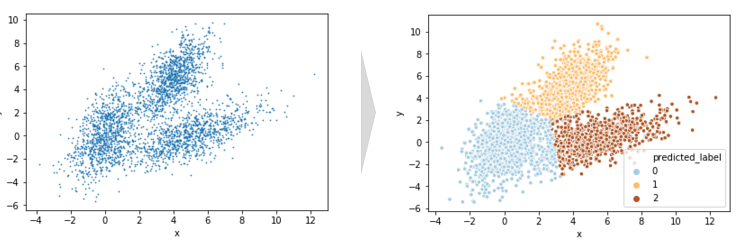

## Task

In this lab, we will implement a slightly more advanced version of K-means clustering: **soft K-means clustering**.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.markers import MarkerStyle
from IPython.display import HTML

## Dataset Preparation

We use a simple dataset containing two important statistics reflecting human development, **fertility rate** and **GDP per capita**, of countries and regions all over the world.  [(source)](https://ourworldindata.org/grapher/children-per-woman-fertility-rate-vs-level-of-prosperity)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/lab4
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/lab4
fertility-rate-vs-level-of-prosperity.csv  lab4_task.ipynb


In [ ]:
# load data from disk (google drive)
df = pd.read_csv('fertility-rate-vs-level-of-prosperity.csv')

# remove missing data
df = df[df['GDP per capita'].notnull()]
df = df[df['Fertility rate'].notnull()]

df

,Entity,Code,Year,Fertility rate,GDP per capita,Population,Continent
617,Albania,ALB,1971,5.0148,3159.8088,2389820.0,NaN
618,Albania,ALB,1972,4.8984,3214.6665,2455181.0,NaN
619,Albania,ALB,1973,4.7643,3267.8481,2520442.0,NaN
620,Albania,ALB,1974,4.6421,3330.0708,2585457.0,NaN
621,Albania,ALB,1975,4.5236,3385.2730,2650128.0,NaN
...,...,...,...,...,...,...,...
58630,Zimbabwe,ZWE,2015,3.8490,2880.9058,14154937.0,Africa
58631,Zimbabwe,ZWE,2016,3.7714,2919.6170,14452705.0,NaN
58632,Zimbabwe,ZWE,2017,3.7064,3112.8750,14751101.0,NaN
58633,Zimbabwe,ZWE,2018,3.6591,3007.2370,15052191.0,NaN


We take the 2019 statistics as an example.

In [ ]:
df_2019 = df[df['Year'] == 2019]
df_2019

,Entity,Code,Year,Fertility rate,GDP per capita,Population,Continent
665,Albania,ALB,2019,1.4142,12531.7880,2873883.0,NaN
924,Algeria,DZA,2019,2.9881,11787.4920,42705372.0,NaN
1556,Angola,AGO,2019,5.4423,7159.5790,32353592.0,NaN
1815,Anguilla,AIA,2019,1.2884,15177.9230,15408.0,NaN
2199,Argentina,ARG,2019,1.9938,21826.8380,44745516.0,NaN
...,...,...,...,...,...,...,...
56022,Uruguay,URY,2019,1.5462,20545.4220,3428412.0,NaN
57270,Vietnam,VNM,2019,1.9481,7506.8170,95776712.0,NaN
57989,Yemen,YEM,2019,3.9626,1777.2511,31546694.0,NaN
58374,Zambia,ZMB,2019,4.4509,3179.1958,18380478.0,NaN


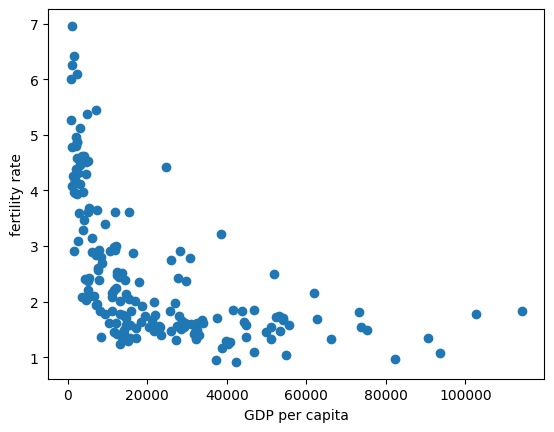

In [ ]:
plt.scatter(df_2019['GDP per capita'], df_2019['Fertility rate'])
plt.xlabel('GDP per capita')
plt.ylabel('fertility rate')
plt.show()

### Data pre-processing
We define a simple data pre-processing function `preprocess` that
1. select data from the Pandas dataframe and store the data in a NumPy array;
2. apply log scaling to GDP per capita values; and
3. scales all the values to be within range from 0 to 1.

We also define `revert_preprocess` that revert the pre-processing for later use.

In [ ]:
def preprocess(df):
    X = np.array(df[['GDP per capita', 'Fertility rate']])
    assert np.all(X > 0)
    X[:, 0] = np.log(X[:, 0])
    X_mins = X.min(axis=0)
    X_maxs = X.max(axis=0)
    X_scaled = (X - X_mins) / (X_maxs - X_mins)
    return X_scaled, X_mins, X_maxs

def revert_preprocess(X, centroids, X_mins, X_maxs):
    X = X * (X_maxs - X_mins) + X_mins
    centroids = centroids * (X_maxs - X_mins) + X_mins
    X[:, 0] = np.exp(X[:, 0])
    centroids[:, 0] = np.exp(centroids[:, 0])
    return X, centroids


X_2019, X_mins_2019, X_maxs_2019 = preprocess(df_2019)
X_2019.shape

(178, 2)

In [ ]:
X_2019[:10]  # take a look at the first 10 countries/regions

array([[0.5558161 , 0.08269806],
       [0.54350309, 0.34296298],
       [0.44323902, 0.74879698],
       [0.59434079, 0.06189539],
       [0.66739868, 0.17854249],
       [0.58838694, 0.10928844],
       [0.74815768, 0.09453806],
       [0.85010705, 0.12499793],
       [0.84710435, 0.09103236],
       [0.60316698, 0.15220016]])

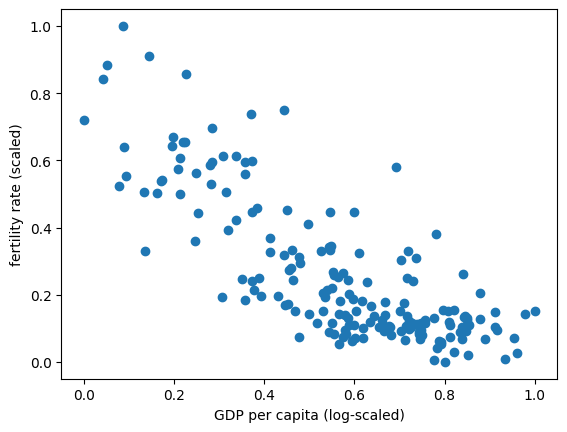

In [ ]:
plt.scatter(*X_2019.T)
plt.xlabel('GDP per capita (log-scaled)')
plt.ylabel('fertility rate (scaled)')
plt.show()

## Soft K-Means

Soft k-means (also known as [fuzzy clustering](https://en.wikipedia.org/wiki/Fuzzy_clustering)) is a form of clustering in which each data point can belong to **more than one** cluster.

Suppose we have $n$ data points $X=\{\mathbf{x}_1, \dots, \mathbf{x}_n\}$, and $k$ cluster centroids $C=\{\mathbf{c}_1, \dots, \mathbf{c}_k\}$.
The shape of $X$ and $C$ are $(n, d)$ and $(k, d)$, respectively, where $d$ is the number of features.

Let matrix $W$ of shape $(n, k)$ be the **soft cluster labels** of $X$.
Every element, $w_{ij}$, of the matrix, is the degree to which data point, $\mathbf{x}_i$, belongs to cluster $\mathbf{c}_j$.
Note that in each row $W_i$, if let the max $w_{ij}$ be 1 while other $w_{ij}$s be 0, this becomes exactly the “hard” k-means or the standard k-means.

The soft k-means algorithm is very similar to the k-means algorithm:

- Choose k random data points as the centroids of the clusters.
- Repeat until the algorithm has converged:
  - For each data point, compute its coefficients $w_{ij}$ of being in the clusters.
  - Compute the centroid for each cluster.
  
### General requirements
Your task is to complete the skeleton code below for an implementation of the soft k-means algorithm. The general requirements are as follows:
- You need to complete the following tasks **using NumPy** efficiently (avoid using loops). You are **not** allowed to use any external library other than NumPy.
- Your code should work for **any numeric dataset** and **number of clusters** ($n$, $k$, and $d$ may change).
- You should not use any global variable in your code.

### Task 1:  Initialize cluster centroids
Your first task is to initialize cluster centroids in function `initialize_centroids`. The centroids should be randomly chosen from the data points $X$. Make sure that the initial centroids are **all different** (i.e. no data point is chosen as centroids more than once).

Input:
- `X`: the data points $X$, a 2D array of shape $(n, d)$.

Output:
- the initial centroids, a 2D array of shape $(k, d)$.

For this task, you may find `np.random.choice` and `np.arange` useful.

### Task 2:  Compute centroids
Given the data points $X$ and the soft labels $W$ at some iteration, compute and return the new centroids in function `compute_centroids`.
The centroids should be computed according to the following formula:
$$\mathbf{c}_j = \frac{\sum_{i}w_{ij}^m \mathbf{x}_i}{\sum_{i}w_{ij}^m}$$

where $m > 1$ is a parameter controlling the "softness" of the clusters. You should **not** hardcode the value of $m$. Its value is specified by `self.m`.

Input:
- `X`: the data points $X$, a 2D array of shape $(n, d)$.
- `soft_labels`: the soft labels $W$, a 2D array of shape $(n, k)$.

Output:
- the new centroids, a 2D array of shape $(k, d)$.

For this task, you may find `np.expand_dims` and `np.sum` useful.

### Task 3: Compute soft labels
Finally, you need to compute the new soft labels $W$ in function `compute_soft_labels`, given the data points $X$ and the current centroids $C$.
The soft labels should be computed according to the following formula:
$$w_{ij} = \left[\sum_{b=1}^k \left(\frac{\mathrm{dist}(\mathbf{x}_i, \mathbf{c}_j) + \epsilon}{\mathrm{dist}(\mathbf{x}_i, \mathbf{c}_b) + \epsilon} \right)^{\frac{2}{m-1}}\right]^{-1}$$

where $\mathrm{dist(\cdot, \cdot)}$ is the Euclidean distance, and $\epsilon = 10^{-6}$ is a small value to avoid division by zero. Note that as $m \to 1$, this becomes the original k-means algorithm. On the other hand, larger $m$ will lead to "softer" clusters.

Input:
- `X`: the data points $X$, a 2D array of shape $(n, d)$.
- `centroids`: the current centroids $C$, a 2D array of shape $(k, d)$.

Output:
- the new soft labels $W$, a 2D array of shape $(n, k)$.

For this task, you may find `np.expand_dims`, `np.sum`, `np.sqrt`, and `np.power` useful.

### Example
Consider the following toy dataset with $n = 3$ and $d = 2$:

$$
X = \begin{bmatrix} 1 & 2 \\ 3 & 4 \\ 5 & 6 \end{bmatrix}.
$$

Here we use the matrix notation. In Python, this means
```
X = np.array([[1, 2],
              [3, 4],
              [5, 6]])
```
and $\mathbf{x}_i$ means `X[i-1]` (similarly for $C$ and $W$ below).

Suppose $k = 2$, we need to pick 2 data points from $X$ as the initial centroids (e.g., the second and the last data points):

$$
C = \begin{bmatrix} 3 & 4 \\ 5 & 6 \end{bmatrix}.
$$

To compute the soft label $w_{12}$, for example, we need to compute $\mathrm{dist}(\mathbf{x}_1, \mathbf{c}_1)$ and $\mathrm{dist}(\mathbf{x}_1, \mathbf{c}_2)$ first:

$$
\begin{align}
    \mathrm{dist}(\mathbf{x}_1, \mathbf{c}_1) &= \sqrt{(1 - 3)^2 + (2 - 4)^2} = 2\sqrt{2}, \\
    \mathrm{dist}(\mathbf{x}_1, \mathbf{c}_2) &= \sqrt{(1 - 5)^2 + (2 - 6)^2} = 4\sqrt{2}.
\end{align}
$$

In Python, this means
```
dist[i, j] = np.sqrt(np.sum((X[i] - C[j]) ** 2))
```

Then, if $m = 2$, we have

$$
    w_{12} = \left[\left(\frac{\mathrm{dist}(\mathbf{x}_1, \mathbf{c}_2) + \epsilon}{\mathrm{dist}(\mathbf{x}_1, \mathbf{c}_1) + \epsilon}\right)^{2} + \left(\frac{\mathrm{dist}(\mathbf{x}_1, \mathbf{c}_2) + \epsilon}{\mathrm{dist}(\mathbf{x}_1, \mathbf{c}_2) + \epsilon}\right)^{2}\right]^{-1} = \left[\left(\frac{4\sqrt{2} + \epsilon}{2\sqrt{2} + \epsilon}\right)^{2} + 1\right]^{-1} \approx \frac{1}{5}.
$$

In Python, this means
```
dist += epsilon
W[i, j] = 1 / np.sum((dist[i, j] / dist[i]) ** 2)
```

Next, suppose at some iteration,

$$
    W = \begin{bmatrix} 0.8 & 0.2 \\ 0.4 & 0.6 \\ 1.0 & 0.0\end{bmatrix}.
$$

The new centroids should be computed as follows (suppose $m = 2$):

$$
\begin{align}
    \mathbf{c}_1 &= \frac{w_{11}^2 \mathbf{x}_1 + w_{21}^2 \mathbf{x}_2 + w_{31}^2 \mathbf{x}_3}{w_{11}^2 + w_{21}^2 + w_{31}^2} = [ 3.4 \quad 4.4 ], \\
    \mathbf{c}_2 &= \frac{w_{12}^2 \mathbf{x}_1 + w_{22}^2 \mathbf{x}_2 + w_{32}^2 \mathbf{x}_3}{w_{12}^2 + w_{22}^2 + w_{32}^2} = [ 2.8 \quad 3.8 ].
\end{align}
$$

In Python, this means
```
Wj_powered = W[:, j] ** 2
C[j] = np.sum(Wj_powered[:, None] * X, axis=0) / np.sum(Wj_powered)
```

In [ ]:
class Soft_K_Means:
    def __init__(self, k, threshold=1e-6, max_iter=1000, m=2):
        self.k = k
        self.threshold = threshold
        self.max_iter = max_iter
        self.m = m

    def initialize_centroids(self, X):
        # Task 1
        index = np.random.choice(np.arange(X.shape[0]), size = self.k)
        c1 = X[index]
        return c1
        # YOUR CODE HERE

    def compute_centroids(self, X, W):
        # Task 2
        c2 = np.zeros((W.shape[1], X.shape[1]))
        num = np.dot((W**self.m).T, X)
        den = np.sum(W**self.m, axis = 0)
        c = num / den[:, np.newaxis]
        return c
        # YOUR CODE HERE

    def compute_soft_labels(self, X, C, epsilon=1e-6):
        # Task 3
        dist = np.sqrt(np.sum((X[:, np.newaxis] - C) ** 2, axis=2))
        dist += epsilon
        power = 2/(self.m-1)
        output = np.zeros((X.shape[0], C.shape[0]))
        inverse_dist = np.reciprocal(dist)
        '''for i in range(X.shape[0]):
          for j in range(C.shape[0]):
            output[i,j] = (dist[i,j]**power) * (np.sum((inverse_dist[i,:])**power))
        '''
        output = (dist ** power) * np.sum(inverse_dist ** power, axis=1)[:, np.newaxis]
        output = 1/output
        return output
        # YOUR CODE HERE

    def fit_one_iteration(self, X, C, W):
        W = self.compute_soft_labels(X, C)
        C = self.compute_centroids(X, W)
        return C, W

    def fit(self, X):
        C = self.initialize_centroids(X)
        W = None
        C_prev = C
        for i in range(self.max_iter):
            C, W = self.fit_one_iteration(X, C, W)
            diff = C - C_prev
            if np.mean(np.sqrt(np.sum(diff ** 2, axis=1))) <= self.threshold:
                break
            C_prev = C
        else:
            print(f'[WARNING] max iter {self.max_iter} reached')
        return C, W

Here are some simple test cases (including the toy example above) to see if your implementation of task 2 & 3 is correct:

In [ ]:
X_toy = np.array([
    [1, 2],
    [3, 4],
    [5, 6]
])
W_toy = np.array([
    [0.8, 0.2],
    [0.4, 0.6],
    [1.0, 0.0]
])
kmeans_toy = Soft_K_Means(2)
kmeans_toy.compute_centroids(X_toy, W_toy)


array([[3.4, 4.4],
       [2.8, 3.8]])

In [ ]:
C_toy = np.array([
    [3, 4],
    [5, 6]
])
kmeans_toy.compute_soft_labels(X_toy, C_toy).round(4)

array([[0.8, 0.2],
       [1. , 0. ],
       [0. , 1. ]])

In [ ]:
C_toy_2 = np.array([
    [1, 0],
    [0, 1]
])
kmeans_toy.compute_soft_labels(X_toy, C_toy_2).round(4)

array([[0.3333, 0.6667],
       [0.4737, 0.5263],
       [0.4902, 0.5098]])

In [ ]:
C_toy_3 = np.array([
    [  0,   0],
    [1.5, 1.5]
])
kmeans_toy.compute_soft_labels(X_toy, C_toy_3).round(4)

array([[0.0909, 0.9091],
       [0.2537, 0.7463],
       [0.3476, 0.6524]])

After the tasks are completed, run the clustering algorithm and then plot the results:

In [ ]:
def preprocess_and_fit(df, year, num_centroids, m=2):
    df_year = df[df['Year'] == year]
    X, X_mins, X_maxs = preprocess(df_year)
    soft_k_means = Soft_K_Means(num_centroids, m=m)
    centroids, soft_labels = soft_k_means.fit(X)
    X, centroids = revert_preprocess(X, centroids, X_mins, X_maxs)
    return X, centroids, soft_labels


YEAR = 2019
NUM_CENTROIDS = 3
X, centroids, soft_labels = preprocess_and_fit(df, YEAR, NUM_CENTROIDS)

# show centroids ordered by GDP per capita
centroids[np.argsort(centroids[:, 0])]
# the results may be slightly different each time due to random initialization
# it is okay for the results to be slightly different

array([[2.48638222e+03, 4.60242145e+00],
       [1.04711621e+04, 2.28778251e+00],
       [3.79752012e+04, 1.58540823e+00]])

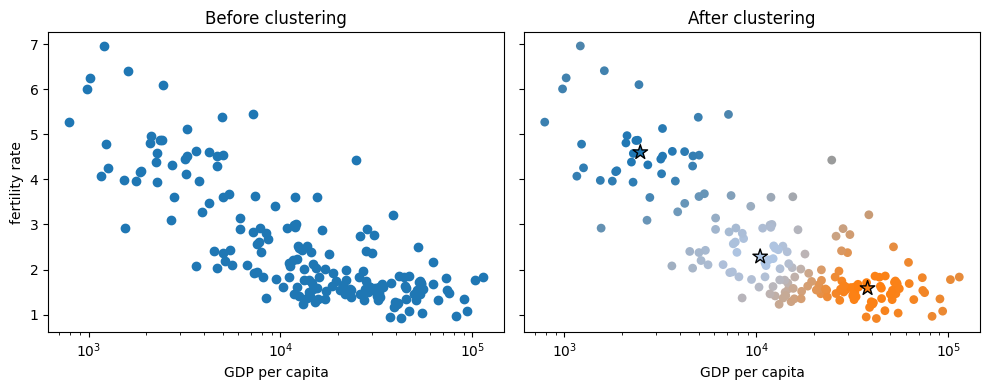

In [ ]:
def draw_clustering_result(scat, X, centroids, soft_labels, index=None, order_by_x=True):
    n, k = soft_labels.shape

    # set the offsets
    points = [X, centroids]
    if index:
        points.append(X[index])
    points = np.vstack(points)                             # (n+k or n+k+1, d)
    scat.set_offsets(points)

    # set the colors
    if k > 20:
        raise ValueError('More than 20 clusters are not supported')
    palette = plt.get_cmap('tab20').colors[:k]             # (k, 3)
    norms = np.linalg.norm(soft_labels, ord=1, axis=1)     # (n,)
    weights = [soft_labels / norms[:, None], np.eye(k)]
    if index:
        weights.append(weights[0][index])
    weights = np.vstack(weights)                           # (n+k or n+k+1, k)
    if order_by_x:
        weights = weights[:, np.argsort(centroids[:, 0])]  # (n+k or n+k+1, 3)
    colors = weights @ palette                             # (n+k or n+k+1, 3)
    scat.set_color(colors)

    # set the markers' shape, size, and edge color
    o_shape = MarkerStyle('o').get_path()
    star_shape = MarkerStyle('*').get_path()
    shapes = [o_shape] * n + [star_shape] * k
    sizes = [10] * n + [30] * k
    edgecolors = ['none'] * n + ['black'] * k
    if index:
        shapes.append(o_shape)
        sizes.append(10)
        edgecolors.append('black')
    scat.set_paths(shapes)
    scat.set_sizes(sizes)
    scat.set_edgecolor(edgecolors)


fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True, layout='tight')
for ax in axs:
    ax.set_xscale('log')
    scat = ax.scatter(*X.T)
    ax.set_xlabel('GDP per capita')
axs[0].set_ylabel('fertility rate')
axs[0].set_title('Before clustering')
axs[1].set_title('After clustering')
draw_clustering_result(scat, X, centroids, soft_labels)

Let's do it again, but this time, we visualize the whole clustering process!

In [ ]:
def animate(results, frame_titles, order_by_x, interval):
    def update(frame):
        ax.set_title(frame_titles[frame])
        draw_clustering_result(scat, *results[frame], order_by_x=order_by_x)
        return scat,

    fig, ax = plt.subplots()
    Xs = np.vstack([r[0] for r in results])
    scat = ax.scatter(*zip(Xs.min(axis=0), Xs.max(axis=0)))
    ax.set_xscale('log')
    ax.set_xlabel('GDP per capita')
    ax.set_ylabel('fertility rate')
    return animation.FuncAnimation(fig, update, frames=len(results), interval=interval, blit=True)

In [ ]:
YEAR = 2019
MAX_ITER = 15
NUM_CENTROIDS = 3

df_year = df[df['Year'] == YEAR]
X, X_mins, X_maxs = preprocess(df_year)
soft_k_means = Soft_K_Means(NUM_CENTROIDS, max_iter=MAX_ITER)

results = []
iterations = []
centroids = soft_k_means.initialize_centroids(X)
X_orig, centroids_orig = revert_preprocess(X, centroids, X_mins, X_maxs)
results.append((X_orig, centroids_orig, np.ones((X_orig.shape[0], centroids_orig.shape[0])), None))
iterations.append(0)

soft_labels = None
prev_centroids = centroids
for i in range(soft_k_means.max_iter):
    centroids, soft_labels = soft_k_means.fit_one_iteration(X, centroids, soft_labels)
    diff = centroids - prev_centroids
    prev_centroids = centroids
    X_orig, centroids_orig = revert_preprocess(X, centroids, X_mins, X_maxs)
    results.append((X_orig, centroids_orig, soft_labels, None))
    iterations.append(i+1)

titles = [f'iteration = {i}' for i in iterations]
ani = animate(results, titles, False, 400)
plt.close()
HTML(ani.to_jshtml())

Let's do some more cool animation to show how things have changed from 1969 to 2019!

In [ ]:
YEAR_START = 1969
YEAR_END = 2019
NUM_CENTROIDS = 3
HIGHLIGHT = 'China'  # you can try other countries/regions, or set this to `None` to remove highlight

results = []
titles = []
for year in range(YEAR_START, YEAR_END+1):
    result = preprocess_and_fit(df, year, NUM_CENTROIDS, m=2)
    index = None
    if HIGHLIGHT:
        entities = df[df['Year'] == year]['Entity'].tolist()
        if HIGHLIGHT not in entities:
            print(f'Data for {HIGHLIGHT} in {year} not found.')
        else:
            index = entities.index(HIGHLIGHT)
    results.append((*result, index))
    titles.append(str(year))

ani = animate(results, titles, True, 200)
plt.close()
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

We can also use animation to clearly show the effect of $m$.



In [ ]:
YEAR = 2000
M_START = 1.1
M_END = 10.1
NUM_CENTROIDS = 3

results = []
titles = []
for m in np.linspace(M_START, M_END, 21):
    result = preprocess_and_fit(df, YEAR, NUM_CENTROIDS, m=m)
    results.append((*result, None))
    titles.append(f'm = {m:.2f}')

ani = animate(results, titles, True, 200)
plt.close()
HTML(ani.to_jshtml())